In [ ]:
from pathlib import Path

from forecasting_models.univariate_models.lstm.model import LSTMForecastModel
import numpy as np
from data_utils.preprocessing import init_preprocess, resample_timeseries_dataframe
from data_utils.csv_utils import read_timeseries_csv


lstm_model = LSTMForecastModel(Path("__file__").parent / Path("examples/configs/lstm/lstm_config_example.yaml"))

<Axes: xlabel='timestamp'>

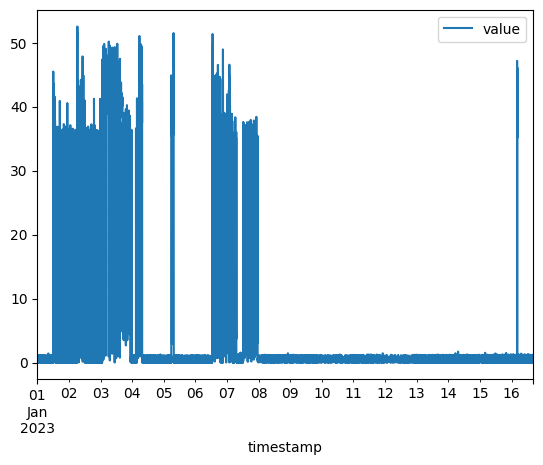

In [2]:
train_df = read_timeseries_csv(lstm_model.config.data_path)
train_df.plot()

<Axes: xlabel='timestamp'>

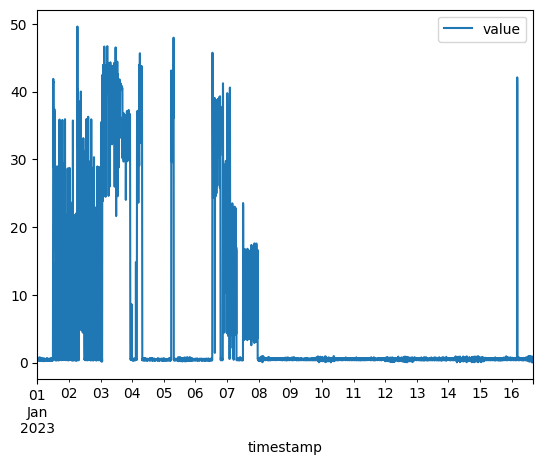

In [3]:
train_df = init_preprocess(
    train_df,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
train_df = resample_timeseries_dataframe(
    train_df,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)
train_df.plot()

In [4]:
import tensorflow as tf

tf.random.set_seed(50)
np.random.seed(50)


In [ ]:
from tensorflow.keras.layers import LSTM

history = lstm_model.train(
    custom_inner_layers=[
        LSTM(16),
    ]
)

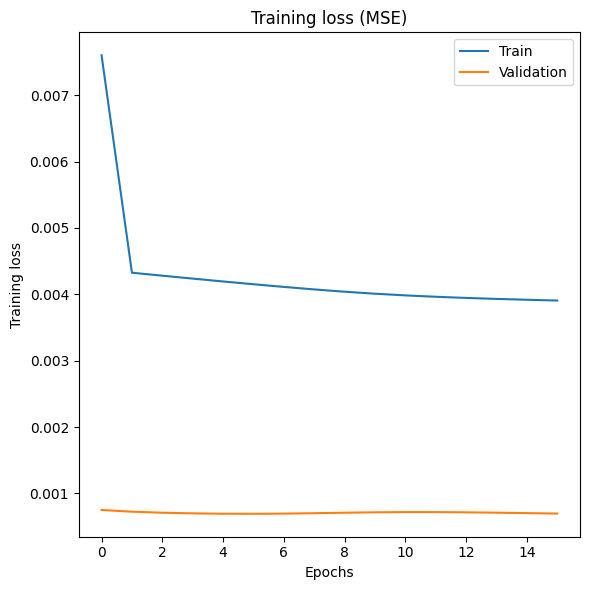

In [6]:
lstm_model.plotter.plot_training_loss(history)

<Axes: xlabel='timestamp'>

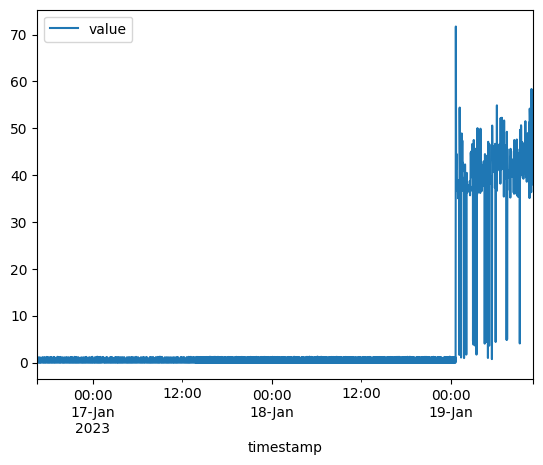

In [7]:
test_df = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_TEST.csv"))
test_df.plot()

(798, 1)


<Axes: xlabel='timestamp'>

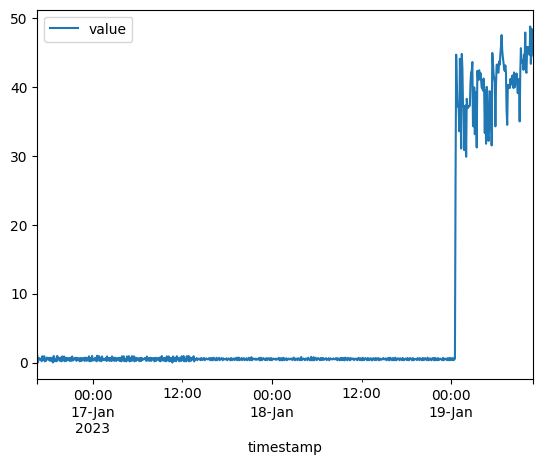

In [8]:
test_df_preprocessed = init_preprocess(
    test_df,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
test_df_preprocessed = resample_timeseries_dataframe(
    test_df_preprocessed,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)

print(test_df_preprocessed.shape)
test_df_preprocessed.plot()

In [9]:
init_inputs = train_df[-lstm_model.config.forecasting_parameters.input_width:]["value"]
print(init_inputs)

actuals, preds = lstm_model.test(
    test_df,
    init_inputs=init_inputs,
)

timestamp
2023-01-16 16:05:00    0.355722
2023-01-16 16:10:00    0.648733
2023-01-16 16:15:00    0.264214
2023-01-16 16:20:00    0.715619
2023-01-16 16:25:00    0.706766
2023-01-16 16:30:00    0.248290
Freq: 5min, Name: value, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

In [10]:
test_eval_val, test_eval_df = lstm_model.evaluate_test(actuals, preds, method="mape")

In [11]:
print(test_eval_df)

                        actual  predicted      diff
2023-01-16 16:35:00   0.955621   2.318579 -1.362958
2023-01-16 16:40:00   0.007500   2.144384 -2.136884
2023-01-16 16:45:00   0.645425   1.309204 -0.663779
2023-01-16 16:50:00   0.445010   1.560813 -1.115803
2023-01-16 16:55:00   0.606107   1.735624 -1.129517
...                        ...        ...       ...
2023-01-19 10:40:00  43.364818  44.161469 -0.796651
2023-01-19 10:45:00  46.298526  42.880410  3.418116
2023-01-19 10:50:00  48.388678  41.877562  6.511116
2023-01-19 10:55:00  47.379692  42.395869  4.983823
2023-01-19 11:00:00  44.573609  40.341532  4.232077

[798 rows x 3 columns]


In [12]:
print(test_eval_val)

364.5107884178052


<Axes: >

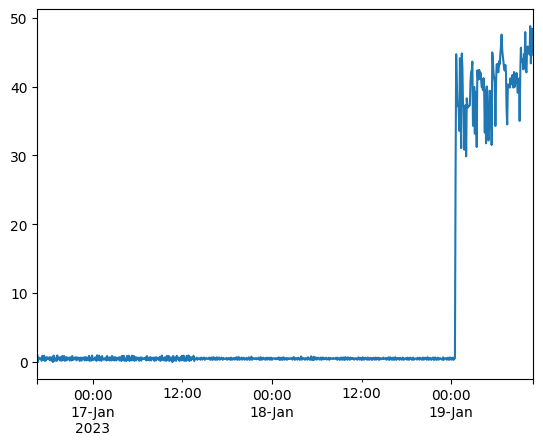

In [13]:
actuals.plot()

<Axes: >

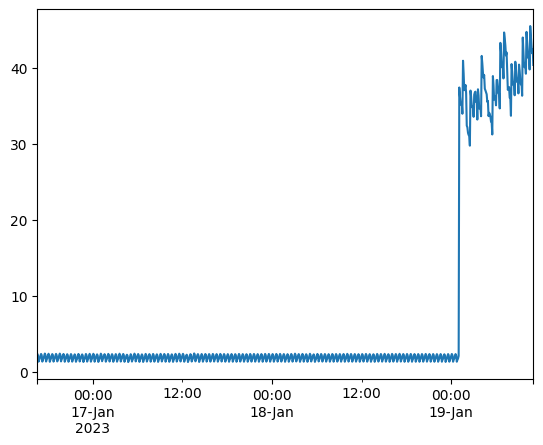

In [14]:
preds.plot()

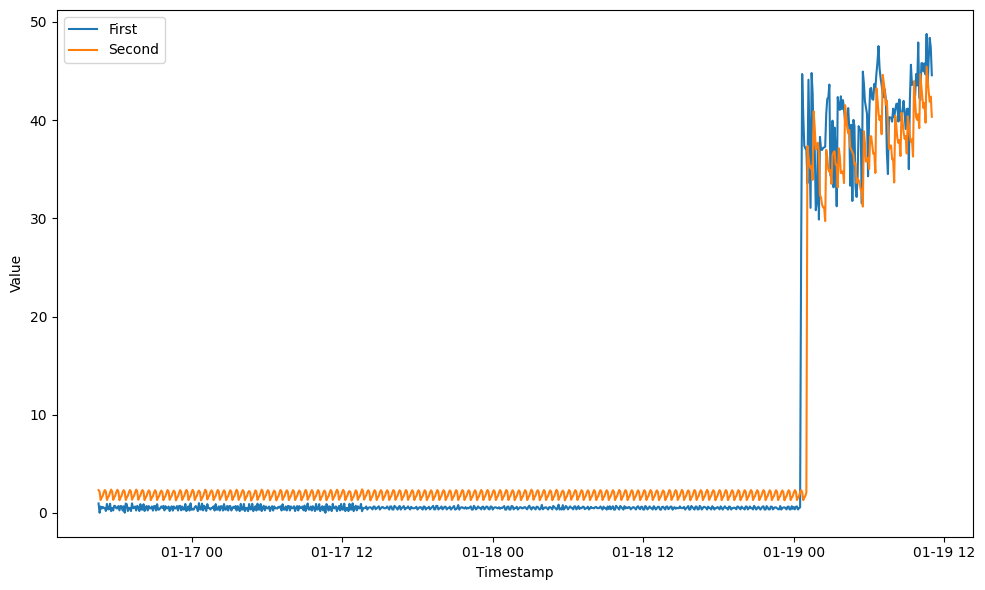

In [15]:
from forecasting_models.general_plotter import GeneralPlotter

GeneralPlotter.plot_two_series(actuals, preds)

In [16]:
anomaly_df = lstm_model.flag_anomalies(actuals, preds, 20)

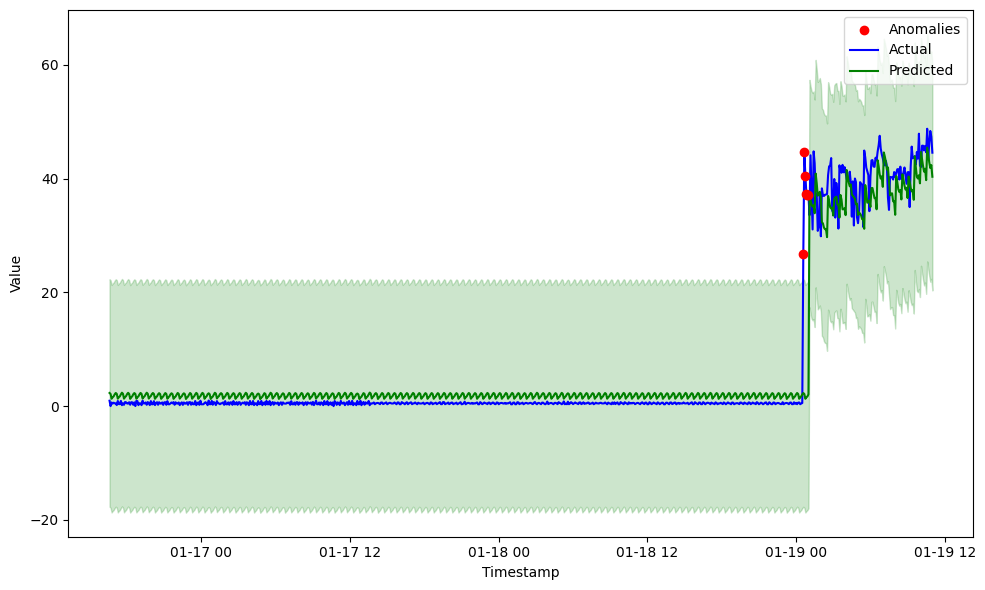

In [17]:
GeneralPlotter.plot_anomalies(anomaly_df, 20)

<Axes: xlabel='timestamp'>

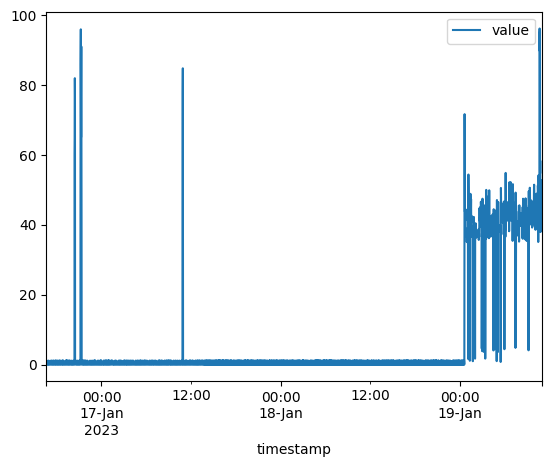

In [18]:
test_df_w_anomalies = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_ANOMALY_TEST.csv"))
test_df_w_anomalies.plot()

<Axes: xlabel='timestamp'>

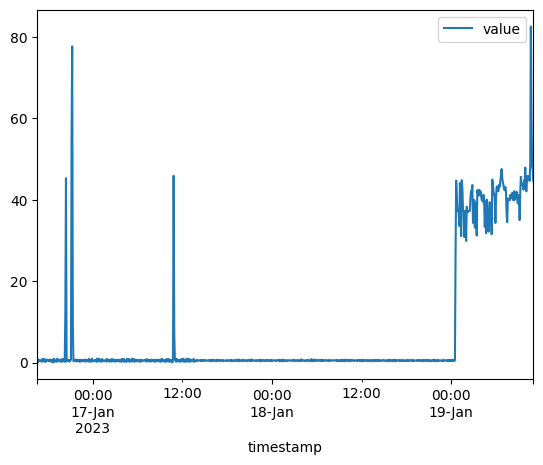

In [19]:
test_df_w_anomalies_preprocessed = init_preprocess(
    test_df_w_anomalies,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
test_df_w_anomalies_preprocessed = resample_timeseries_dataframe(
    test_df_w_anomalies_preprocessed,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)
test_df_w_anomalies_preprocessed.plot()

In [20]:
anomaly_actuals, anomaly_preds = lstm_model.test(test_df_w_anomalies, init_inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━

In [21]:
new_anomaly_df = lstm_model.flag_anomalies(anomaly_actuals, anomaly_preds, 20)

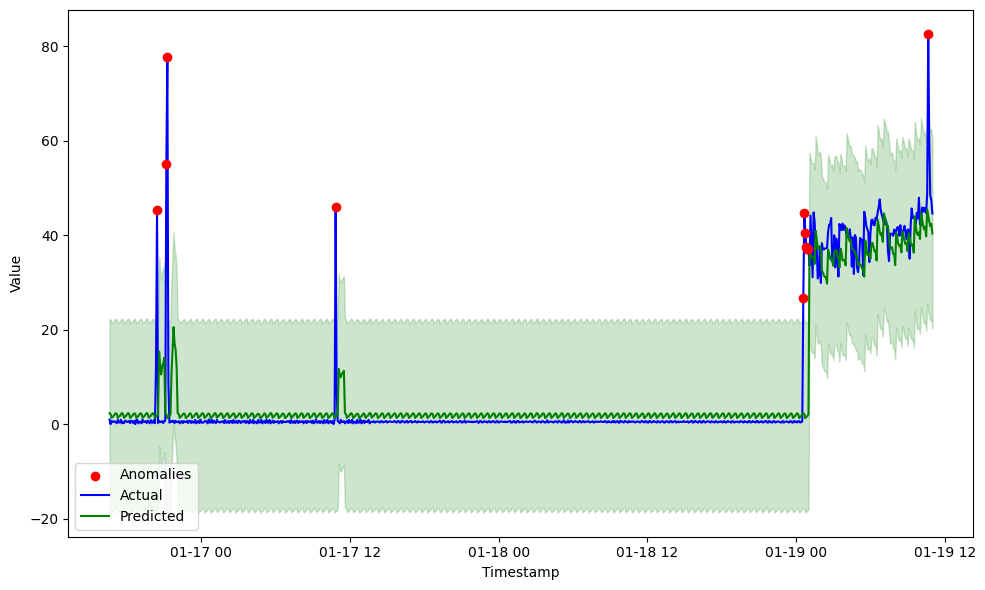

In [22]:
GeneralPlotter.plot_anomalies(new_anomaly_df, 20)

In [23]:
single_shot_prediction_inputs = train_df[:lstm_model.config.forecasting_parameters.input_width]["value"]
print(single_shot_prediction_inputs)

timestamp
2023-01-01 00:00:00    0.458009
2023-01-01 00:05:00    0.482082
2023-01-01 00:10:00    0.347365
2023-01-01 00:15:00    0.630353
2023-01-01 00:20:00    0.316106
2023-01-01 00:25:00    0.489296
Freq: 5min, Name: value, dtype: float64


In [24]:
single_shot_predictions = lstm_model.predict(single_shot_prediction_inputs)
print(single_shot_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2023-01-01 00:30:00    2.268418
2023-01-01 00:35:00    2.103654
2023-01-01 00:40:00    1.264068
2023-01-01 00:45:00    1.511957
2023-01-01 00:50:00    1.686467
2023-01-01 00:55:00    2.031736
Freq: 5min, dtype: float64


In [25]:
single_shot_prediction_actuals = train_df[
    lstm_model.config.forecasting_parameters.input_width:(
            lstm_model.config.forecasting_parameters.input_width + lstm_model.config.forecasting_parameters.output_width
        )]["value"]

single_shot_eval_val, single_shot_eval_df = lstm_model.evaluate_prediction(single_shot_prediction_actuals, method="mse")

In [26]:
print(single_shot_eval_df)

                       actual  predicted      diff
2023-01-01 00:30:00  0.490616   2.268418 -1.777802
2023-01-01 00:35:00  0.490828   2.103654 -1.612826
2023-01-01 00:40:00  0.348003   1.264068 -0.916065
2023-01-01 00:45:00  0.465542   1.511957 -1.046415
2023-01-01 00:50:00  0.607025   1.686467 -1.079442
2023-01-01 00:55:00  0.313061   2.031736 -1.718675


In [27]:
print(single_shot_eval_val)

1.969163803851193
